In [1]:
%matplotlib inline

In [196]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from plotly import graph_objs as go
plotly.offline.init_notebook_mode()

In [227]:
def _axis_title_font_layout():
    return {'family': 'Courier New, monospace', 'size': 18, 'color': '#7f7f7f'}


def time_series_plot(df, variable, figure_title=None, yaxis_range=None, yaxis_title=None):
    # generate the data for the figure...
    trace = go.Scatter(x=df.index, y=df[variable])
    data = [trace]

    # create a layout for the figure...
    xaxis_layout = {'title': 'Time', 'titlefont': _axis_title_font_layout()}
    yaxis_layout = {'range': yaxis_range, 'title': yaxis_title, 'titlefont': _axis_title_font_layout()}
    layout = go.Layout(title=figure_title,
                       xaxis=xaxis_layout,
                       yaxis=yaxis_layout,
                      )
    
    # combine data and layout to create the figure...
    fig = go.Figure(data=data, layout=layout)
    
    return fig


def ecdf_plot(series, upper=False, figure_title=None, xaxis_title=None, xaxis_type=None,
              yaxis_type=None, yaxis_range=None, yaxis_title=None):
    
    # generate the data for the figure...
    ecdf = sm.distributions.ECDF(series)
    if upper:
        trace = go.Scatter(x=ecdf.x, y=1 - ecdf.y)
    else:
        trace = go.Scatter(x=ecdf.x, y=ecdf.y)
    data = [trace]

    # create a layout for the figure...
    xaxis_layout = {'title': xaxis_title, 'type': xaxis_type, 'titlefont': _axis_title_font_layout()}
    yaxis_layout = {'range': yaxis_range, 'type': yaxis_type, 'title': yaxis_title, 'titlefont': _axis_title_font_layout()}
    layout = go.Layout(title=figure_title,
                       xaxis=xaxis_layout,
                       yaxis=yaxis_layout,
                      )
    
    # combine data and layout to create the figure...
    fig = go.Figure(data=data, layout=layout)
    
    return fig


def kde_plot(series, upper=False, figure_title=None, xaxis_title=None, xaxis_type=None,
             yaxis_type=None, yaxis_range=None, yaxis_title=None):
    
    # generate the data for the figure...
    clean_series = series.dropna()
    kde = sm.nonparametric.KDEUnivariate(clean_series)
    kde.fit(fft=True)
    xs = clean_series.sort_values().values
    trace = go.Scatter(x=xs, y=kde.evaluate(xs))
    data = [trace]

    # create a layout for the figure...
    xaxis_layout = {'title': xaxis_title, 'type': xaxis_type, 'titlefont': _axis_title_font_layout()}
    yaxis_layout = {'range': yaxis_range, 'type': yaxis_type, 'title': 'Density', 'titlefont': _axis_title_font_layout()}
    layout = go.Layout(title=figure_title,
                       xaxis=xaxis_layout,
                       yaxis=yaxis_layout,
                      )
    
    # combine data and layout to create the figure...
    fig = go.Figure(data=data, layout=layout)
    
    return fig

In [73]:
!sbt "run-main ZeroIntelligenceApp"

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Running ZeroIntelligenceApp 
[info] -XX:InitialHeapSize=268435456 -XX:MaxHeapSize=4294967296 -XX:+PrintCommandLineFlags -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseParallelGC 
[success] Total time: 6 s, completed Mar 24, 2016 5:34:29 PM


<h2> Importing the raw data </h2>

In [74]:
# this is a bit of a hack as current log files are not valid JSON!
with open('./data/fills.log') as data_file:    
    zi_data = pd.read_json('[%s]' % ','.join(data_file.read().splitlines()))
    zi_data.set_index('timestamp', inplace=True)

In [75]:
zi_data.describe()

,askPrice,bidPrice,price,quantity
count,4468.000000,4468.000000,4468.000000,4468
mean,78.873545,122.589078,101.030439,1
std,44.903806,44.700409,30.728473,0
min,1.000000,26.000000,26.000000,1
25%,40.000000,84.000000,76.000000,1
50%,78.000000,122.000000,101.000000,1
75%,117.000000,161.000000,126.000000,1
max,159.000000,199.000000,159.000000,1


<h3> Compute the bid-ask spread...</h3>

In [91]:
zi_data['spread'] = zi_data.bidPrice - zi_data.askPrice

In [92]:
zi_data.spread.describe()

count    4468.000000
mean       43.715533
std        29.678742
min         1.000000
25%        20.000000
50%        39.000000
75%        62.000000
max       150.000000
Name: spread, dtype: float64

<h3> Compute raw returns </h3>

$$ r_{t+k} = \frac{p_{t+k} - p_{t}}{p_{t}} = \frac{\Delta p_{t+k}}{p_{t}}$$ 

Note that raw returns are bounded below! Bounds on price (at least in these simulations!) are $1 \le p_t \le \overline{p}$. Therefore lower bound on raw returns is...

$$ \underline{r} = \frac{1 - \overline{p}}{\overline{p}} \approx -1. $$

Similarly, then upper bound on raw returns is...

$$ \underline{r} = \frac{\overline{p} - 1}{1} \approx \overline{p}. $$


In [94]:
zi_data['raw_returns'] = zi_data.price.pct_change(periods=1)

In [95]:
zi_data.raw_returns.describe()

count    4467.000000
mean        0.094068
std         0.490602
min        -0.787234
25%        -0.225458
50%         0.000000
75%         0.274336
max         4.576923
Name: raw_returns, dtype: float64

In [197]:
# render the plot locally in the notebook
fig = time_series_plot(zi_data, 'raw_returns', figure_title="Zero Intelligence Agents",
                       yaxis_title='Raw Returns')
plotly.offline.iplot(fig)

<h2> Compute logarithmic returns </h2>

Starting from raw returns, $r_{t+k}$ we see that...

$$ 1 + r_{t+k} = 1 + \frac{p_{t+k} - p_t}{p_t} = \frac{p_{t+k}}{p_t} $$

...taking logs yields...

$$ \ln \big(1 + r_{t+k}\big) = \ln p_{t+k} - \ln p_t = \Delta \ln p_{t+k} $$

...since $\ln \big(1 + r_{t+k}\big) \approx r_{t+k}$ for $r << 1$ we should expect that raw and logarithmic return formulas should yields similar results for "small" returns.


In [82]:
zi_data['log_returns'] = np.log(1 + zi_data.raw_returns)

In [158]:
# render the plot locally in the notebook
fig = time_series_plot(zi_data, 'log_returns', figure_title="Zero Intelligence Agents",
                       yaxis_title='Logarithmic Returns')
plotly.offline.iplot(fig)

In [228]:
# render the plot locally in the notebook
fig = kde_plot(zi_data.log_returns, figure_title="Zero Intelligence Agents", xaxis_title='Logarithmic Returns')
plotly.offline.iplot(fig)

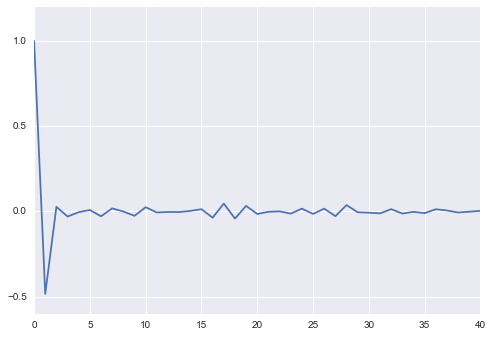

In [85]:
plt.plot(sm.tsa.acf(zi_data.log_returns.dropna(), fft=True))
plt.show()

<h3> Price impact </h3>

In [86]:
zi_data['mid_price'] = 0.5 * (zi_data.askPrice + zi_data.bidPrice)

How to best measure effective size? Particularly of ask orders!

In [87]:
zi_data['effective_size'] = zi_data.quantity

incoming_ask_orders = zi_data.bidPrice == zi_data.price
zi_data.loc[incoming_ask_orders, 'effective_size'] *= -zi_data.loc[incoming_ask_orders, 'askPrice']

incoming_bid_orders = zi_data.askPrice == zi_data.price
zi_data.loc[incoming_bid_orders, 'effective_size'] *= zi_data.loc[incoming_bid_orders, 'bidPrice']

Compute the measure of price impact: $\Delta \ln$ `mid_price`...

In [88]:
zi_data['price_impact'] = np.log(zi_data.mid_price).diff()

In [89]:
zi_data[incoming_ask_orders].head()

,askPrice,bidPrice,class,price,quantity,tradable,spread,raw_returns,log_returns,mid_price,effective_size,price_impact
timestamp,,,,,,,,,,,,
2016-03-24 17:34:24.317,80,128,markets.Fill,128,1,Gpi2,48,0.882353,0.632523,104.0,-80,0.333592
2016-03-24 17:34:24.317,21,30,markets.Fill,30,1,Gpi2,9,-0.787234,-1.547563,25.5,-21,-1.842726
2016-03-24 17:34:24.317,4,26,markets.Fill,26,1,Gpi2,22,-0.133333,-0.143101,15.0,-4,-0.530628
2016-03-24 17:34:24.317,56,92,markets.Fill,92,1,Gpi2,36,-0.365517,-0.454945,74.0,-56,-0.752181
2016-03-24 17:34:24.318,25,68,markets.Fill,68,1,Gpi2,43,-0.381818,-0.480973,46.5,-25,-1.008664


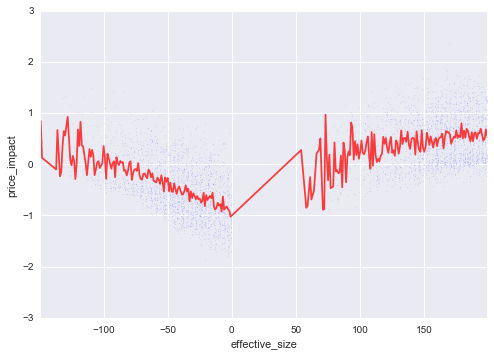

In [90]:
# incoming bid orders
fig, ax = plt.subplots(1, 1)
grouped_data = zi_data.groupby("effective_size")
grouped_data.price_impact.mean().plot(color='r', alpha=0.75, ax=ax)
ax.scatter(zi_data.effective_size, zi_data.price_impact, edgecolor='b', s=1, alpha=0.05)
ax.set_ylabel("price_impact")
plt.show()

## Cumulative distributions

In [31]:
ecdfs = {} 
for column_name in ['raw_returns', 'log_returns']:
    ecdfs[column_name] = sm.distributions.ECDF(zi_data[column_name].abs())

In [164]:
fig = ecdf_plot(zi_data.log_returns.abs(), upper=True, figure_title="Zero Intelligence Agents",
                xaxis_type='log', xaxis_title='Absolute Logarithmic Returns', yaxis_type='log')
plotly.offline.iplot(fig)

In [165]:
fig = ecdf_plot(zi_data.raw_returns.abs(), upper=True, figure_title="Zero Intelligence Agents",
                xaxis_type='log', xaxis_title='Absolute Raw Returns', yaxis_type='log')
plotly.offline.iplot(fig)

<h3> Zero Intelligence Constrained </h3>

Endow traders with exogenous valuations and impose the requirement that traders never offer to buy (sell) a tradable at a price that is higher (lower) than their respective valuations of the tradable. Traders still choose their limit prices randomly, so in this sense traders still have "zero intelligence," its just that the support of the distribution from which these random limit prices are drawn is truncated to reflect their valuations.

In [185]:
!sbt "run-main ZeroIntelligenceConstrainedApp"

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Running ZeroIntelligenceConstrainedApp 
[info] -XX:InitialHeapSize=268435456 -XX:MaxHeapSize=4294967296 -XX:+PrintCommandLineFlags -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseParallelGC 
[success] Total time: 10 s, completed Mar 26, 2016 1:25:34 PM


In [186]:
# this is a bit of a hack as current log files are not valid JSON!
with open('./data/fills.log') as data_file:    
    zic_data = pd.read_json('[%s]' % ','.join(data_file.read().splitlines()))
    zic_data.set_index('timestamp', inplace=True)

In [187]:
zic_data.describe()

,askPrice,bidPrice,price,quantity
count,13203.000000,13203.000000,13203.000000,13203
mean,83.892827,113.983564,98.770961,1
std,28.921467,29.177444,15.108754,0
min,0.000000,71.000000,71.000000,1
25%,64.000000,90.000000,86.000000,1
50%,89.000000,109.000000,99.000000,1
75%,108.000000,134.000000,111.000000,1
max,167.000000,198.000000,189.000000,1


In [188]:
zic_data['spread'] = zic_data.bidPrice - zic_data.askPrice
zic_data['raw_returns'] = zic_data.price.pct_change(periods=1)
zic_data['log_returns'] = np.log(1 + zic_data.raw_returns)

In [189]:
# render the plot locally in the notebook
fig = time_series_plot(zic_data, 'spread', figure_title="Constrained Zero Intelligence Agents",
                       yaxis_range=[0, 200], yaxis_title='Bid-Ask Spread')
plotly.offline.iplot(fig)

In [190]:
# render the plot locally in the notebook
fig = time_series_plot(zic_data, 'price', figure_title="Constrained Zero Intelligence Agents",
                       yaxis_range=[1, 200], yaxis_title='Asset Price')
plotly.offline.iplot(fig)

In [191]:
# render the plot locally in the notebook
fig = time_series_plot(zic_data, 'log_returns', figure_title="Unconstrained Zero Intelligence Agents",
                       yaxis_title='Logarithmic Returns')
plotly.offline.iplot(fig)

<h2> Imposing budget constraints on traders reduces spreads...</h2>

In [192]:
zi_data.spread.describe()

count    4468.000000
mean       43.715533
std        29.678742
min         1.000000
25%        20.000000
50%        39.000000
75%        62.000000
max       150.000000
Name: spread, dtype: float64

In [193]:
zic_data.spread.describe()

count    13203.000000
mean        30.090737
std         21.871710
min          1.000000
25%         12.000000
50%         26.000000
75%         44.000000
max        136.000000
Name: spread, dtype: float64

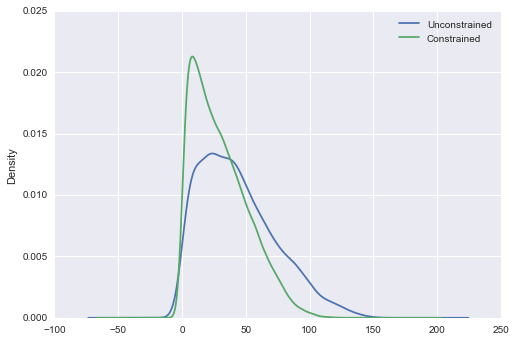

In [194]:
zi_data.spread.dropna().plot(kind='kde', label='Unconstrained')
zic_data.spread.dropna().plot(kind='kde', label='Constrained')
plt.legend()

plt.show()

<h2> Imposing budget constraints on traders reduces variance in returns...</h2>

In [43]:
zi_data.log_returns.describe()

count    99744.000000
mean         0.000027
std          0.451085
min         -1.474000
25%         -0.272415
50%          0.000000
75%          0.269523
max          2.224624
Name: log_returns, dtype: float64

In [44]:
zic_data.log_returns.describe()

count    32289.000000
mean        -0.000007
std          0.182676
min         -0.746257
25%         -0.106295
50%          0.000000
75%          0.105361
max          0.571786
Name: log_returns, dtype: float64

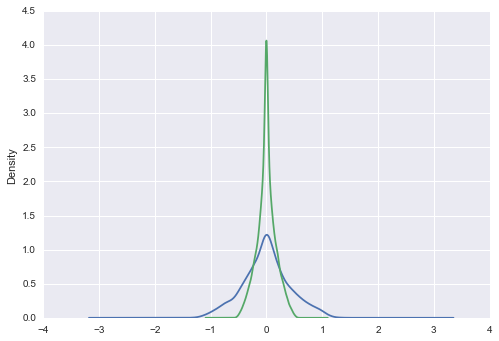

In [184]:
zi_data.log_returns.dropna().plot(kind='kde', label='Unconstrained')
zic_data.log_returns.dropna().plot(kind='kde', label='Constrained')
plt.show()